In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io

### Cone Equation
* Differential form:
$\ \tau_c \frac{dr}{dt} = \alpha_cy(t)-[1+\beta_cz(t)][r(t))+\varphi h(t)]\\ 
\tau_h \frac{dh}{dt} = \alpha_hy_h(t)-[1+\beta_hz_h(t)]h(t) $

* Simplified form:
$\ r(t) = \frac{\alpha_cy(t)}{1+\beta_cz(t)}-h(t) \\
h(t) = \alpha_h\int_{-\infty}^{t}Kh(t-t')r(t')dt' $

In [2]:
# # Solve DE by Runge-Kutta method
# def ODE_RK4(f, t0, tf, y0=0, n=100):
#     t = np.linspace(t0, tf, n)
#     y = list([y0])
#     for i in range(n-1):
#         h = t[i+1]-t[i]
#         k1 = h*f(t[i], y[-1])
#         k2 = h*f(t[i]+h/2.0, y[-1]+k1/2.0)
#         k3 = h*f(t[i]+h/2.0, y[-1]+k2/2.0)
#         k4 = h*f(t[i]+h, y[-1]+k3)
#         y.append(y[-1]+(k1+2*k2+2*k3+k4)/6.0)
#     y = np.array(y)
#     return y

In [3]:
# def f(t, r):
#     alpha_c = 2.4e-4 
#     beta_c = 1.148e-5
#     gamma = 0.764
#     tau_y = 0.056
#     tau_z = 0.5769
#     tau_h = 0.371
#     Tk = np.arange(0,5,dt)
#     K_y = Tk*np.exp(-Tk/tau_y)/tau_y**2
#     K_z = gamma*K_y + (1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2
#     K_h = Tk*np.exp(-Tk/tau_h)/tau_h**2
#     K_y = K_y/np.sum(K_y)
#     K_z = K_z/np.sum(K_z)
#     K_h = K_h/np.sum(K_h)
#     y = np.convolve(x, K_y)
#     y = y[0:len(x)]
#     z = np.convolve(x, K_z)
#     z = z[0:len(x)]
#     return (alpha_c*y-(1+beta)*r+phi*h)/tau_c

# def f(t, h):
#     K_h = Tk*np.exp(-Tk/tau_h)/tau_h**2
#     y_h = np.convolve(x, K_h)
#     return (-h-beta_h*z_h*h+alpha_h*y_h)/tau_h

In [4]:
def Cone(x, phi):
    # Set parameters
    alpha_c = 2.4e-4  #-9.602e-6 in paper but used 2.4e-4 in code
    beta_c = 1.148e-5
    alpha_h = 0.5292
    gamma = 0.764 
    tau_y = 0.056
    tau_z = 0.5769
    tau_h = 0.371
    # Set functions
    Tk = np.arange(0,5,dt)
    K_y = Tk*np.exp(-Tk/tau_y)/tau_y**2
    K_z = gamma*K_y + (1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2
    K_h = Tk*np.exp(-Tk/tau_h)/tau_h**2
    K_y = K_y/np.sum(K_y) #Normalize
    K_z = K_z/np.sum(K_z)
    K_h = K_h/np.sum(K_h)
    y = np.convolve(x, K_y)
    y = y[0:len(x)]
    z = np.convolve(x, K_z)
    z = z[0:len(x)]
    # set r, h
    r = np.zeros(len(x))
    h = np.zeros(len(x))
    for i in range(len(x)-1): 
        if i - len(K_h)+1<0:
            K_ht = K_h[::-1][-i-1:len(K_h)]
            h[i] = alpha_h*sum(K_ht*r[0:len(K_ht)])
        else:
            K_ht = K_h[::-1]
            h[i] = alpha_h*sum(K_ht*r[i-len(K_ht)+1:i+1])
        r[i]=alpha_c*y[i]/(1+beta_c*z[i])-phi*h[i]
    return r,h

In [5]:
# Light input from Drinnenberg's paper
lightlevels = scipy.io.loadmat('lightLevels.mat')
light = lightlevels['R_s'][:,1] # light intensity
dt = 0.001
ad = 20
du = 1.86
adaptation = np.ones(int(ad/dt))
stimulus = np.ones(int(du/dt))
x_D = light[0]*adaptation
for i in range(len(light)-1):
    x_D = np.append(x_D, light[i+1]*stimulus)
T_D = np.arange(dt,ad+du*8+1e-7,dt)


In [6]:
# Input signal
Tot = 300
dt = 0.01
T = np.arange(dt,Tot,dt)

#HMM
Gamma = 4 # Tried 0.5 to 4
Omega = Gamma / 2.12
D = 27*10**5
HMM = np.zeros(len(T))
vL = np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1] = HMM[i]+vL[i]*dt
    vL[i+1] = vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+np.sqrt(D*dt)*np.random.normal(mu,sigma)

#OU
tau = 3
D = 27*10**5
OU = np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1] = OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)

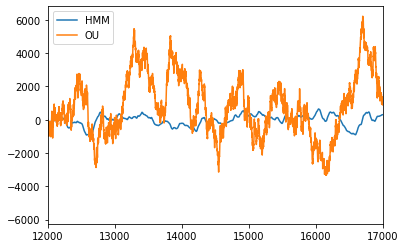

In [7]:
plt.plot(HMM,label = 'HMM')
plt.plot(OU, label = 'OU')
plt.xlim(12000, 12000+5000)
plt.legend()
plt.show()

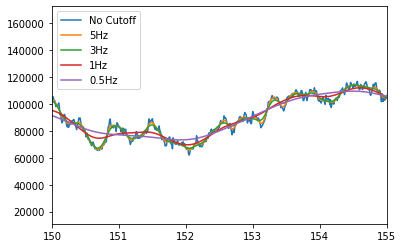

In [8]:
# Low-pass filtering for OU signal
CutoffFreq = [5, 3, 1, 0.5]
LPOU = np.zeros([len(CutoffFreq)+1, len(T)])
LPOU[0] = OU
label_list = ['No Cutoff']
for i in range(len(CutoffFreq)):
    b, a = signal.butter(2, 2*CutoffFreq[i]*dt, btype='low', analog=False)
    LP = signal.filtfilt(b, a, OU)
    LPOU[i+1,:] = LP
    label_list.append(str(CutoffFreq[i]) +'Hz')
for i in range(len(CutoffFreq)+1):
    LPOU[i]=LPOU[i]/np.mean(LPOU[i])*1500 + np.mean(light) # Revised
    plt.plot(T, LPOU[i], label = label_list[i])
plt.legend()
plt.xlim(150, 150+5)
plt.show()

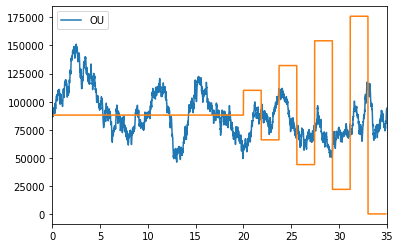

In [9]:
# Compared OU signal amplitude to the one in Drinnenberg's paper
plt.plot(T, LPOU[0], label = 'OU')
plt.plot(T_D,x_D)
plt.xlim(0,35)
plt.legend()
plt.show()

In [10]:
# OU Signal as input
r1_OU = np.zeros([len(LPOU), len(LPOU[0])])
h1_OU = np.zeros([len(LPOU), len(LPOU[0])])
for i in range(len(LPOU)):
    r1_OU[i], h1_OU[i] = Cone(LPOU[i], 1)

In [11]:
def EqualState(x, num_state):
    xs = np.sort(x)
    binlen = int(len(x)/num_state - 0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate = np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [12]:
def MI(xstate, ystate, dt, window):
    negshift = window[0] # second
    posshift = window[1] # second
    shiftdu = dt # second
    shiftlen = (posshift - negshift)/dt+1
    timeshift = np.linspace(negshift, posshift, int(shiftlen))
    bitshift = np.linspace(negshift/dt, posshift/dt, int(shiftlen))
    xedges = np.arange(min(xstate), max(xstate) + 0.0001)
    yedges = np.arange(min(ystate), max(ystate) + 0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue = np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx = []
        yy = []
        shift = int(bitshift[i])
        if shift>0:
            xx = xstate[shift:]
            yy = ystate[:-shift]
        elif shift == 0:
            xx = xstate
            yy = ystate
        elif shift<0:
            xx = xstate[:shift]
            yy = ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins = (xedges, yedges))
        statesum = np.sum(H)
        px_list = np.sum(H,axis = 1)/statesum
        py_list = np.sum(H,axis = 0)/statesum
        pxy_list = H/statesum

        MIsingle = np.zeros((len(px_list), len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy] == 0:
                    MIsingle[ix][iy] = 0
                else:
                    MIsingle[ix][iy] = pxy_list[ix][iy]*np.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i] = np.sum(MIsingle)
    return timeshift, MIvalue

In [13]:
MI1_OU = [[] for i in range(len(LPOU))]
for i in range(len(LPOU)):
    timeshift,MI1_OU[i] = MI(EqualState(LPOU[i],8),EqualState(r1_OU[i],8),dt,[-1,1])
MI1_OU = np.array(MI1_OU)

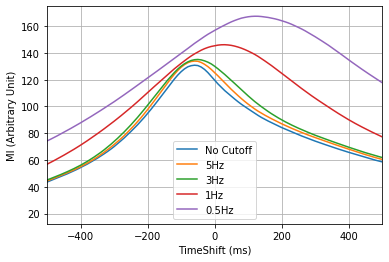

In [14]:
for i in range(len(LPOU)):
    plt.plot(timeshift*1000, MI1_OU[i], label = label_list[i]) 
    plt.legend()
    plt.xlabel('TimeShift (ms)')
    plt.ylabel('MI (Arbitrary Unit)')
plt.xlim(-500,500)
plt.grid()
plt.show()


In [15]:
# Without feedback
r0_OU = np.zeros([len(LPOU), len(LPOU[0])])
h0_OU = np.zeros([len(LPOU), len(LPOU[0])])
for i in range(len(LPOU)):
    r0_OU[i], h0_OU[i] = Cone(LPOU[i], 0)

In [16]:
MI0_OU = [[] for i in range(len(LPOU))]
for i in range(len(LPOU)):
    timeshift,MI0_OU[i] = MI(EqualState(LPOU[i],8),EqualState(r0_OU[i],8),dt,[-1,1])
MI0_OU = np.array(MI0_OU)

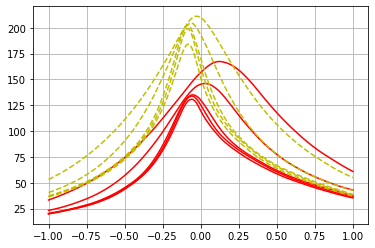

In [17]:
for i in range(len(LPOU)):
    plt.plot(timeshift,MI1_OU[i], c = 'r',)
for i in range(len(LPOU)):
    plt.plot(timeshift,MI0_OU[i], c = 'y', linestyle = 'dashed')
plt.grid()
plt.show()

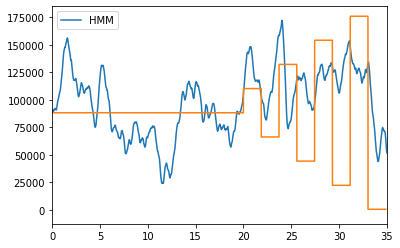

In [18]:
# HMM Signal as input
HMM = HMM*100+np.mean(light)
plt.plot(T, HMM, label = 'HMM')
plt.plot(T_D,x_D)
plt.xlim(0,35)
plt.legend()
plt.show()

### HMM

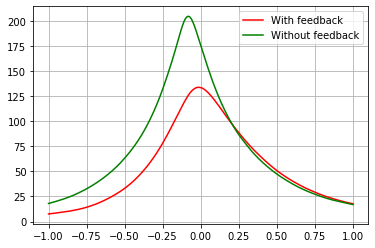

In [19]:
# With feedback and without feedback
r1_HMM, h1_HMM = Cone(HMM, 1)
r0_HMM, h0_HMM = Cone(HMM, 0)
timeshift,MI1_HMM = MI(EqualState(HMM,8),EqualState(r1_HMM,8),dt,[-1,1])
timeshift,MI0_HMM = MI(EqualState(HMM,8),EqualState(r0_HMM,8),dt,[-1,1])
plt.plot(timeshift,MI1_HMM, c = 'r', label = 'With feedback')
plt.plot(timeshift,MI0_HMM, c = 'g', label = 'Without feedback')
plt.legend()
plt.grid()
plt.show()

In [20]:
r1_HMM = -4*r1_HMM
r0_HMM = -4*r0_HMM

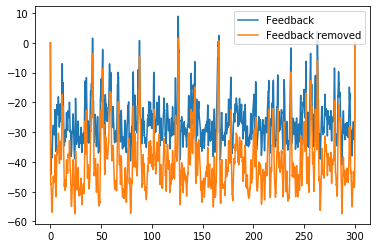

In [21]:
plt.plot(T,r1_HMM, label = 'Feedback')
plt.plot(T,r0_HMM, label = 'Feedback removed')
plt.legend()
# plt.xlim(150,150+100)
# plt.ylim(0,200)
plt.show()

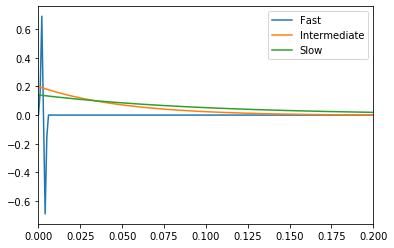

In [22]:
# Bipolar pathway
dt = 0.001
mu = 3e-3
sigma = 1e-3
tau2 = 5e-2
tau3 = 1e-1
c2 = 50
Tk2 = np.arange(0,10,dt)
K1 = np.sin(np.pi*Tk2/mu)*np.exp(-1/2*((Tk2-mu)/sigma)**2)/np.sqrt(2*np.pi*sigma) #fast pathway
K2 = np.exp(-Tk2/tau2)/tau2 - np.exp(-Tk2/(c2*tau2))/(c2*tau2) # intermediate pathway
K3 = np.exp(-Tk2/tau3)/tau3 # slow pathway

K1 = K1/np.sqrt(np.sum(K1**2))
K2 = K2/np.sqrt(np.sum(K2**2))
K3 = K3/np.sqrt(np.sum(K3**2))
plt.plot(Tk2, K1, label = 'Fast')
plt.plot(Tk2, K2, label = 'Intermediate')
plt.plot(Tk2, K3, label = 'Slow')
plt.legend()
plt.xlim(0,0.2)
plt.show()

In [23]:
def Bipolar(r_in):
    v_dark = 23
    K_1_2_3 = np.array([K1,K2,K3])
    theta_p_k = np.array([[0.1,-0.1], [0,0], [-23.5,-23.5]]) # theta_p_k = theta[p][k]
    b_p_k = np.zeros([3,2,(len(r_in)-len(K1)+1)]) # 3x2x31880 array
    r_baseline = r_in + v_dark
    for i in range(3):
        for j in range(2):
            b_p_k[i][j] = (-1)**j*(np.convolve(r_baseline, K_1_2_3[i], 'valid') - theta_p_k[i][j])
            for k in range(len(b_p_k[i][j])):
                if b_p_k[i][j][k] < 0:
                    b_p_k[i][j][k] = 0
    return b_p_k

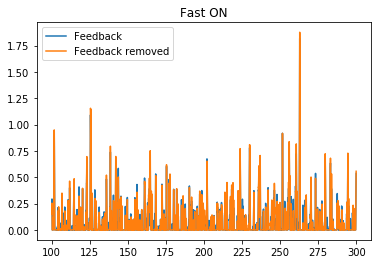

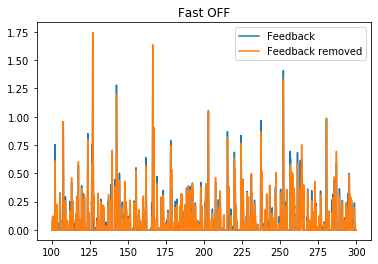

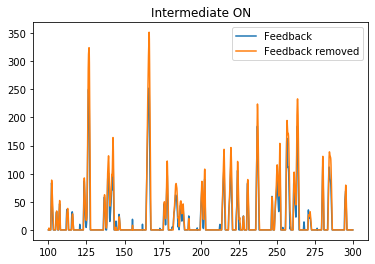

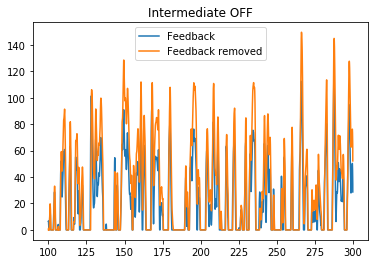

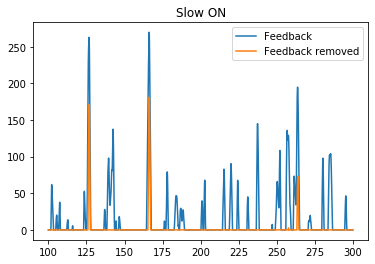

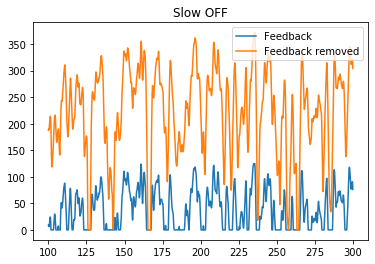

In [24]:
br1_HMM = Bipolar(r1_HMM)
br0_HMM = Bipolar(r0_HMM)
titlelist = [['Fast ON', 'Fast OFF'],
             ['Intermediate ON','Intermediate OFF'],
             ['Slow ON', 'Slow OFF']]
for i in range(3):
    for j in range(2):
        plt.plot(T[len(K1)-1:], br1_HMM[i][j], label = 'Feedback')
        plt.plot(T[len(K1)-1:], br0_HMM[i][j], label = 'Feedback removed')
        plt.title(titlelist[i][j])
        plt.legend()
        plt.show()
# plt.xlim(27,30)
# plt.ylim(0,3000)

In [25]:
class RGC:
    alpha = np.array([1,0,0,1,0,0])
    theta = np.array([0.3,0.1,0,0,-0.1,0])
    weight = np.zeros([6,3,2])
    ind = np.array([[0,1,1],[1,1,1],[2,1,1],[2,2,1],[3,0,0],[3,1,1],[4,1,0],[4,2,0],[5,0,1]])
    list_RGC = [1,1,4,1,3,-1,1,10,1]
    weight[ind[:,0],ind[:,1],ind[:,2]] = list_RGC
    
    def __init__(self):
        pass
    def output(w_gpk, alpha_g, theta_g, b):
        Ig = 0
        for p in range(len(w_gpk)):
            for k in range(len(w_gpk[0])):
                Ig = Ig + w_gpk[p][k]*b[p][k]
        Ig_velocity = np.convolve(Ig, K1, 'valid')
        Ig = Ig[len(K1)-1:]
        R = (1-alpha_g)*Ig + alpha_g*Ig_velocity - theta_g
        R[R<0] = 0
        return R

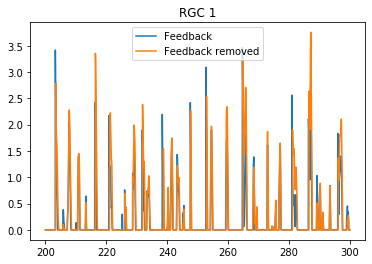

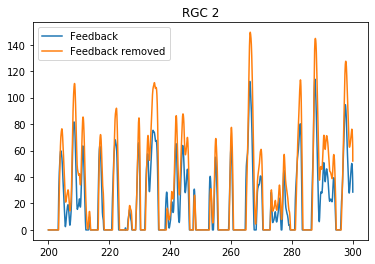

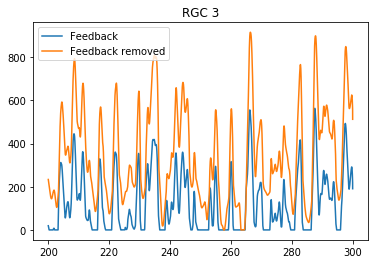

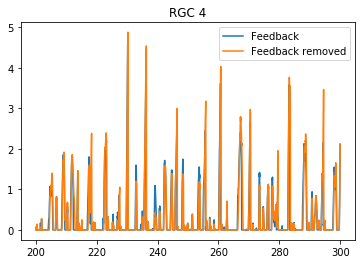

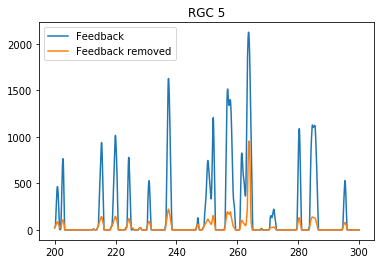

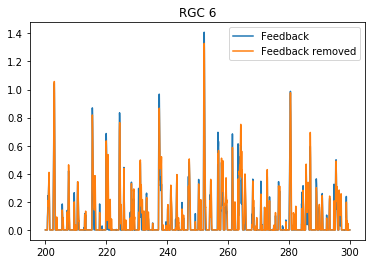

In [26]:
# 7 RGC simulation plot 
for i in range(len(RGC.weight)):
    G1_HMM = RGC.output(RGC.weight[i], RGC.alpha[i], RGC.theta[i], br1_HMM)
    G0_HMM = RGC.output(RGC.weight[i], RGC.alpha[i], RGC.theta[i], br0_HMM)
    plt.plot(T[len(K1)*2-2:], G1_HMM, label = 'Feedback')
    plt.plot(T[len(K1)*2-2:], G0_HMM, label = 'Feedback removed')
    plt.title("RGC {}".format(i+1))
#     plt.xlim(15, 35)
    # plt.ylim(0, 10)
    plt.legend()
    plt.show()

### MI

In [27]:
HMM = HMM[len(K1)*2-2:]

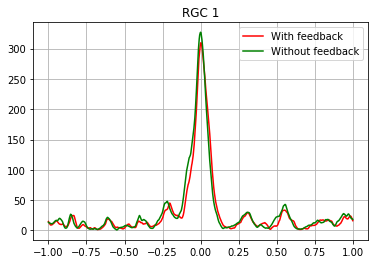

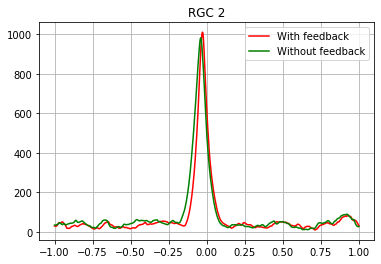

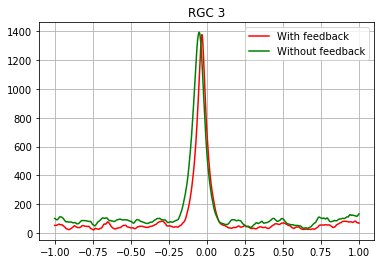

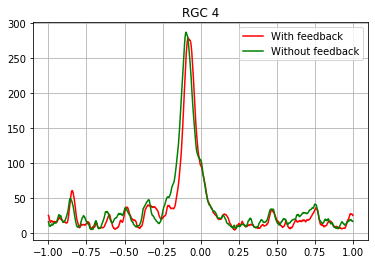

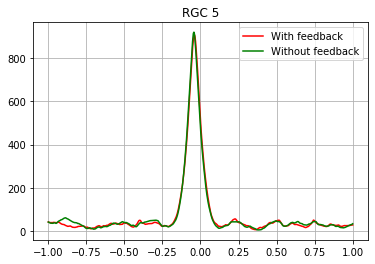

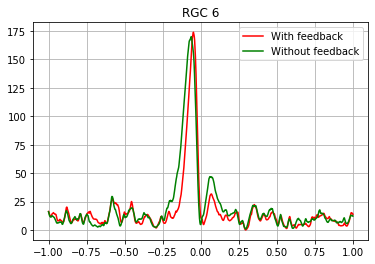

In [28]:
for i in range(len(RGC.weight)):
    G1_HMM = RGC.output(RGC.weight[i], RGC.alpha[i], RGC.theta[i], br1_HMM)
    G0_HMM = RGC.output(RGC.weight[i], RGC.alpha[i], RGC.theta[i], br0_HMM)
    timeshift,MI1_HMM = MI(EqualState(HMM,8),EqualState(G1_HMM,8),dt,[-1,1])
    timeshift,MI0_HMM = MI(EqualState(HMM,8),EqualState(G0_HMM,8),dt,[-1,1])
    plt.plot(timeshift,MI1_HMM, c = 'r', label = 'With feedback')
    plt.plot(timeshift,MI0_HMM, c = 'g', label = 'Without feedback')
    plt.title("RGC {}".format(i+1))
#     plt.xlim(-0.25,0.25)
    # plt.ylim(0, 10)
    plt.legend()
    plt.grid()
    plt.show()

### OU

In [29]:
for i in range(len(LPOU)):
    r1_OU = -4*r1_OU
    r0_OU = -4*r0_OU

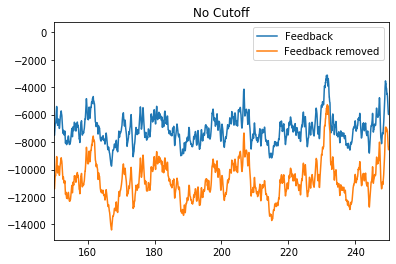

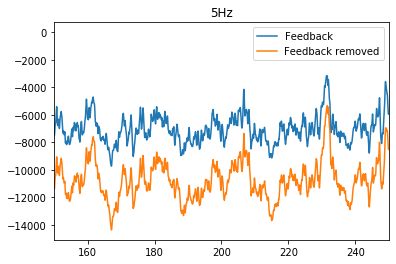

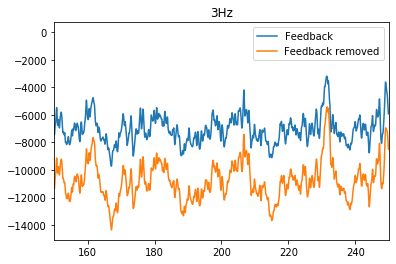

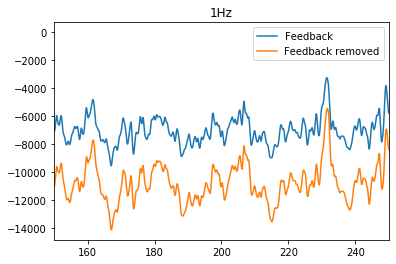

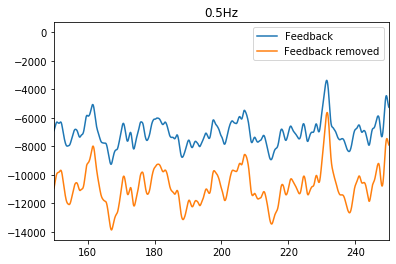

In [30]:
for i in range(len(LPOU)):
    plt.plot(T,r1_OU[i], label = 'Feedback')
    plt.plot(T,r0_OU[i], label = 'Feedback removed')
    plt.legend()
    plt.title(label_list[i])
    plt.xlim(150,150+100)
    plt.show()

In [31]:
br1_OU = [[] for i in range(len(LPOU))]
br0_OU = [[] for i in range(len(LPOU))]
for j in range(len(LPOU)):
    br1_OU[j] = Bipolar(r1_OU[j])
    br0_OU[j] = Bipolar(r0_OU[j])

In [32]:
len(br1_OU[0][0][0])

20000

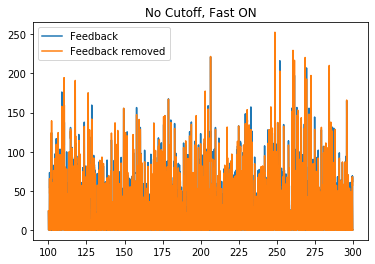

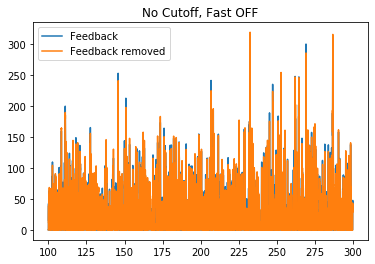

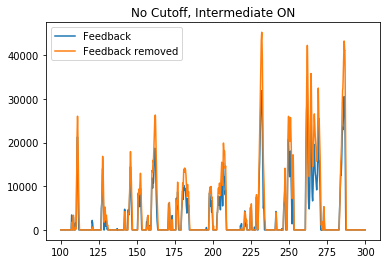

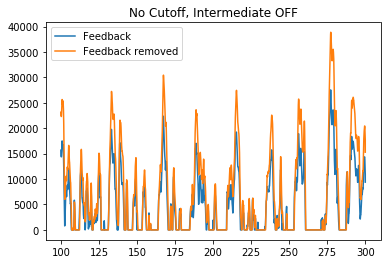

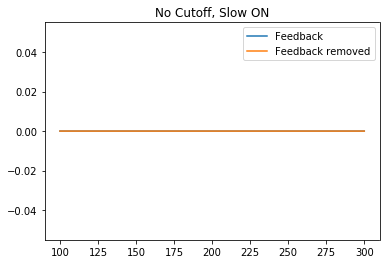

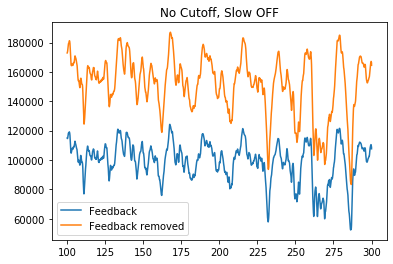

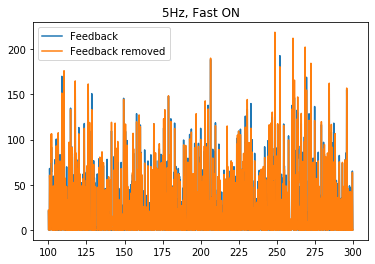

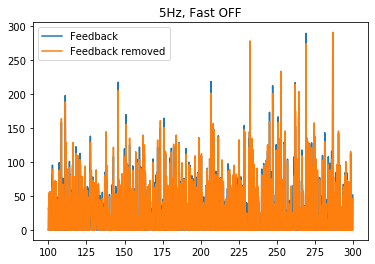

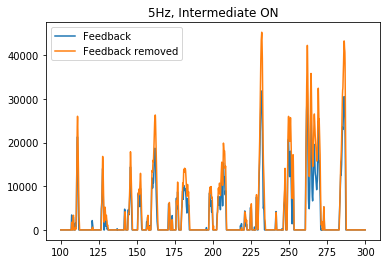

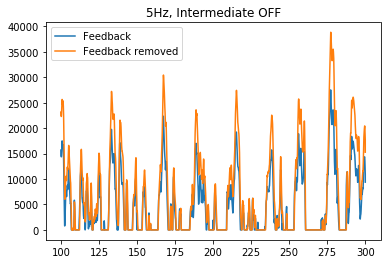

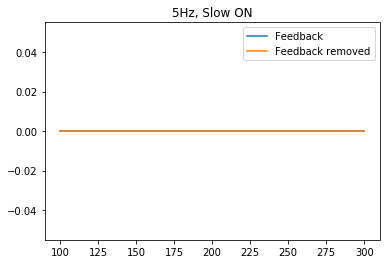

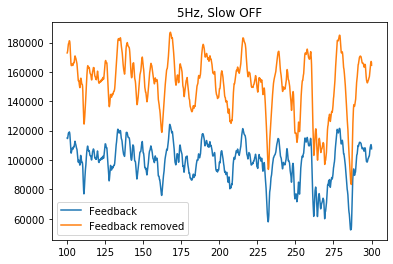

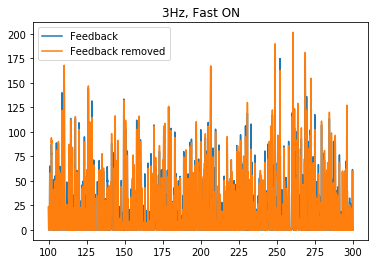

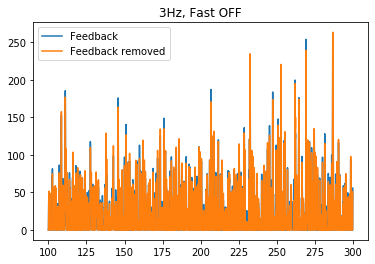

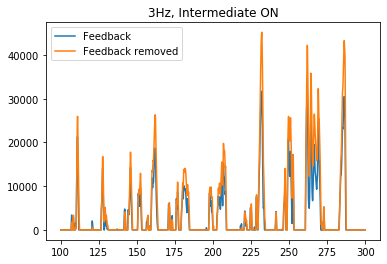

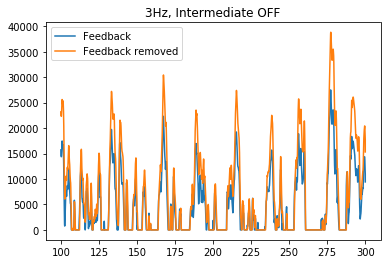

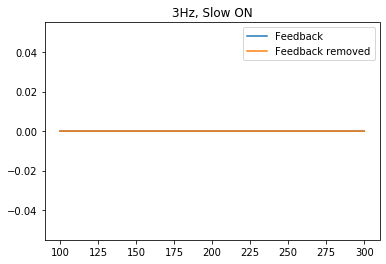

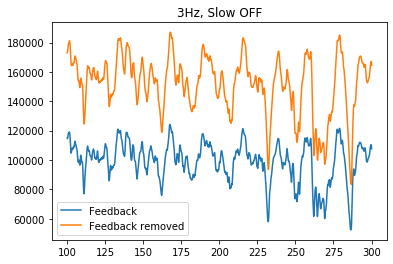

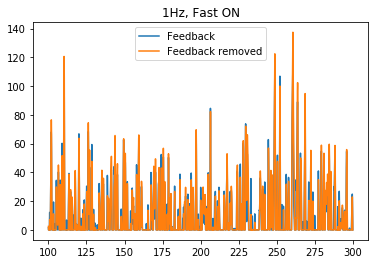

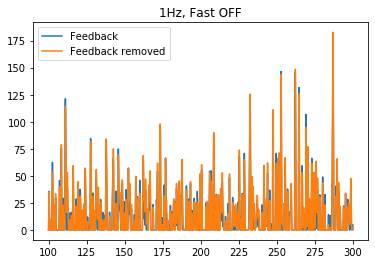

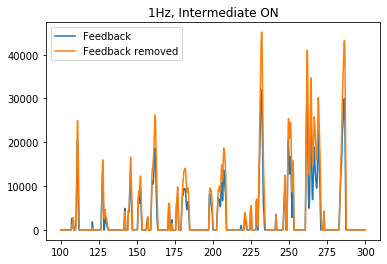

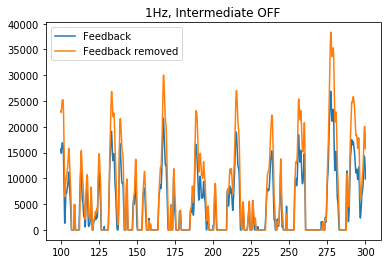

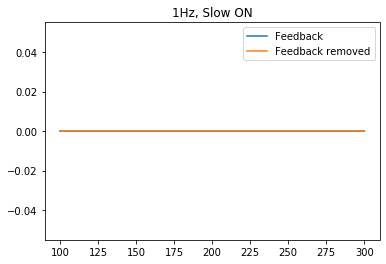

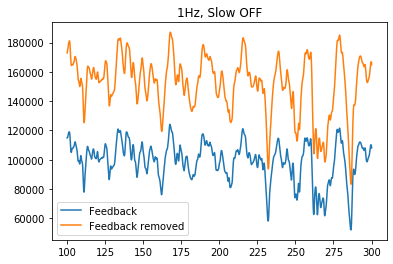

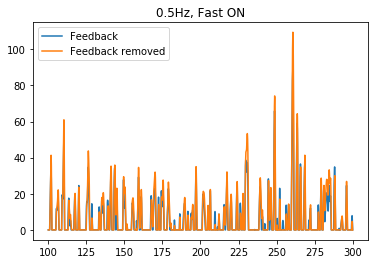

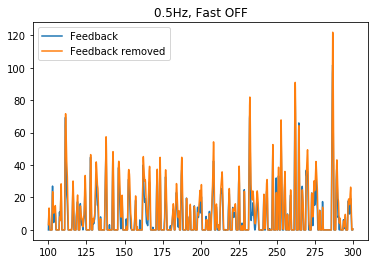

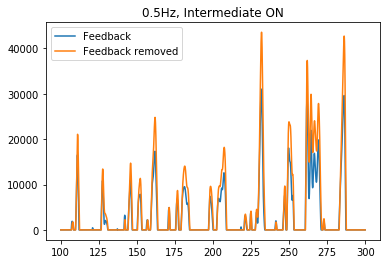

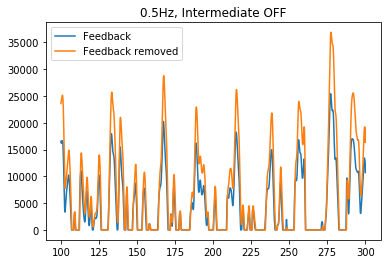

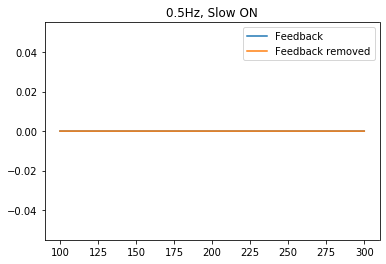

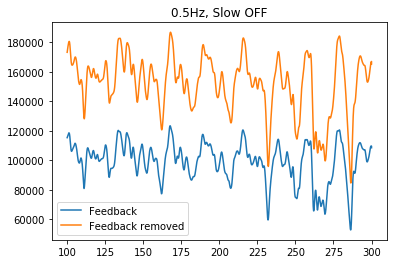

In [33]:
titlelist = [['Fast ON', 'Fast OFF'],
            ['Intermediate ON','Intermediate OFF'],
            ['Slow ON', 'Slow OFF']]
for i in range(len(LPOU)):
    for j in range(3):
        for k in range(2):
            plt.plot(T[len(K1)-1:], br1_OU[i][j][k], label = 'Feedback')
            plt.plot(T[len(K1)-1:], br0_OU[i][j][k], label = 'Feedback removed')
            plt.title(label_list[i]+', '+titlelist[j][k])
            plt.legend()
            plt.show()
        # plt.xlim(27,30)
        # plt.ylim(0,3000)

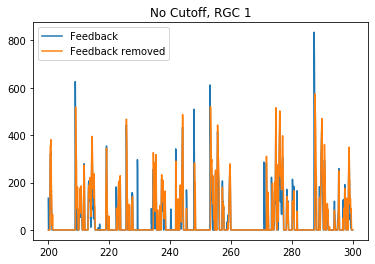

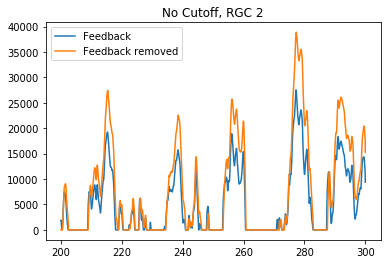

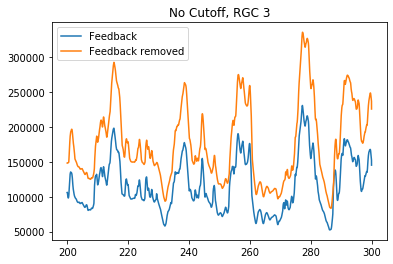

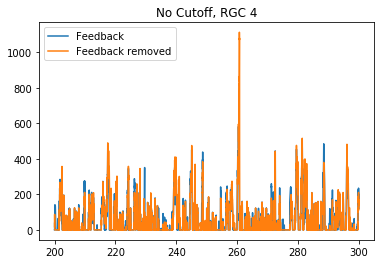

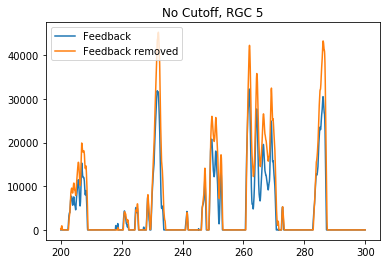

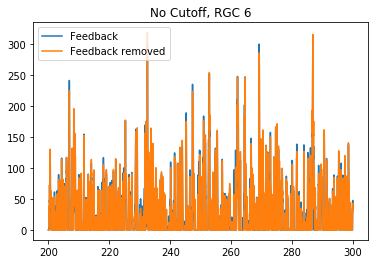

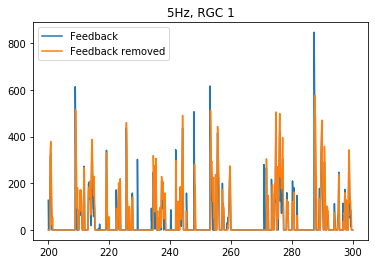

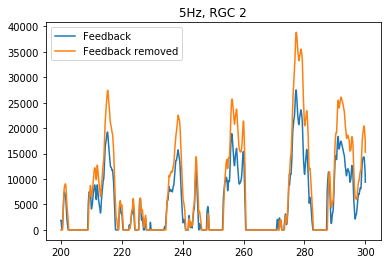

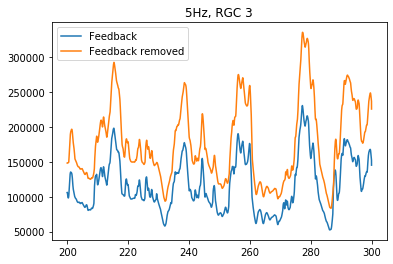

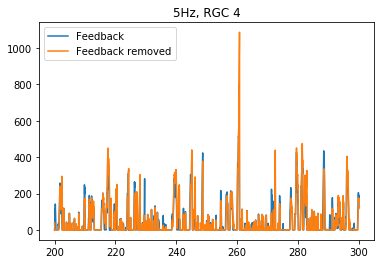

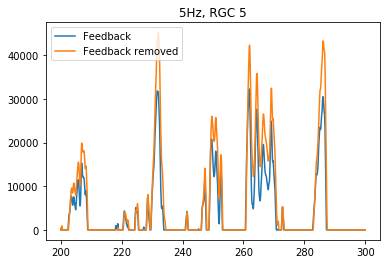

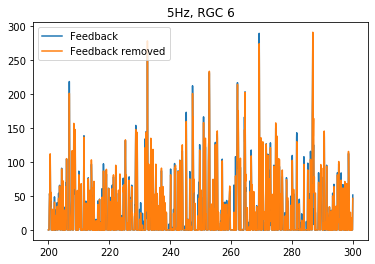

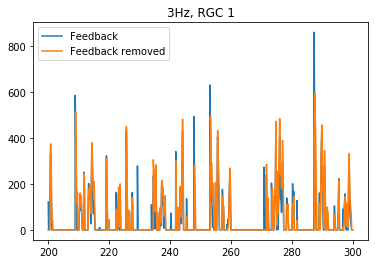

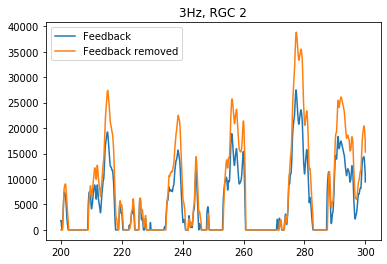

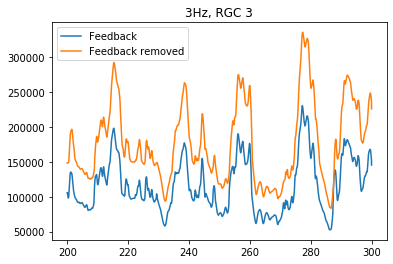

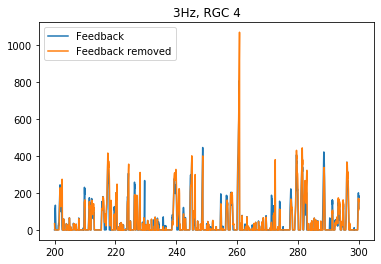

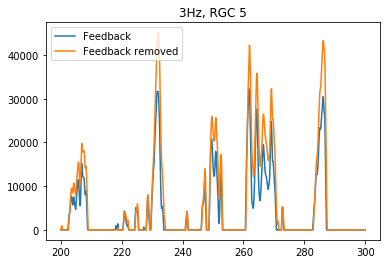

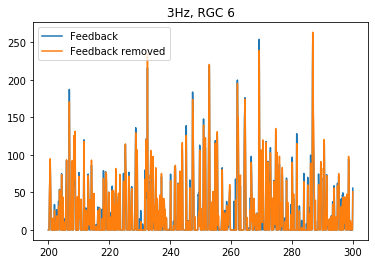

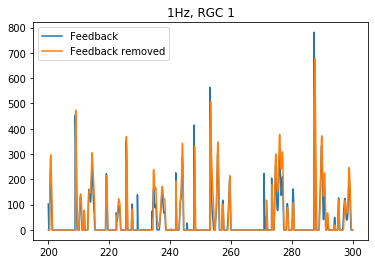

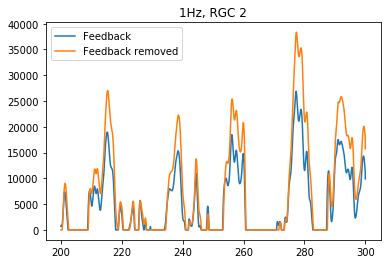

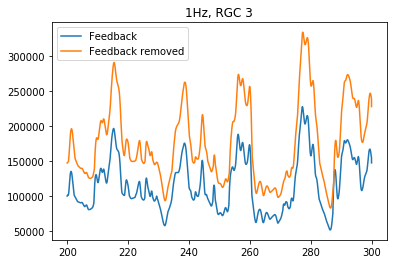

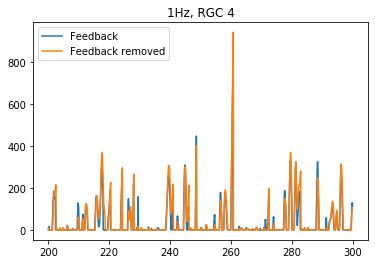

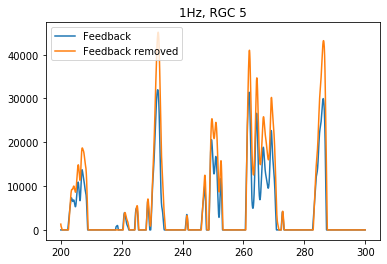

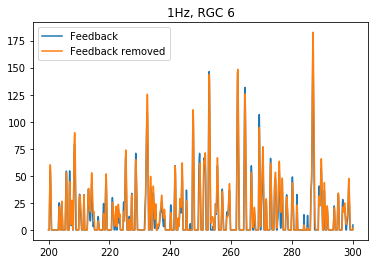

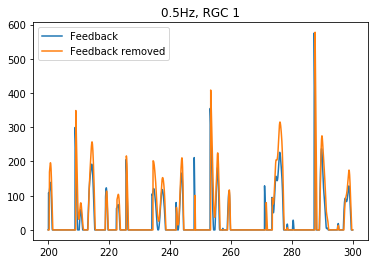

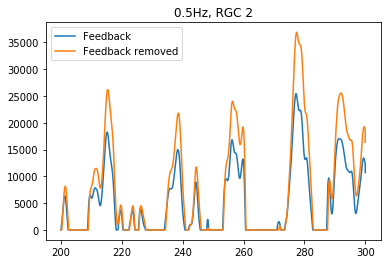

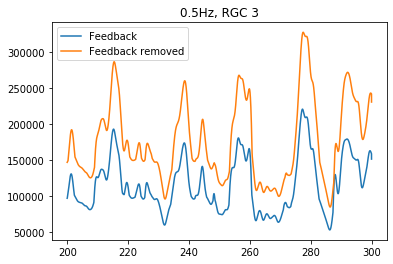

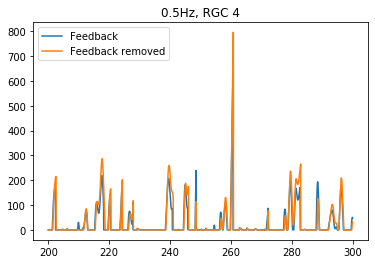

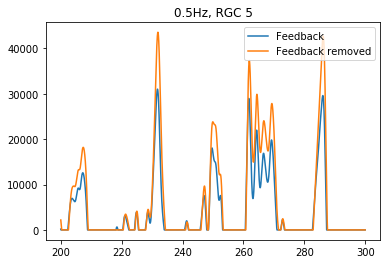

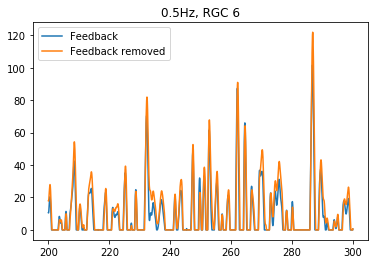

In [34]:
# 7 RGC simulation plot 
for i in range(len(LPOU)):
    for j in range(len(RGC.weight)):
        G1_OU = RGC.output(RGC.weight[j], RGC.alpha[j], RGC.theta[j], br1_OU[i])
        G0_OU = RGC.output(RGC.weight[j], RGC.alpha[j], RGC.theta[j], br0_OU[i])
        plt.plot(T[len(K1)*2-2:], G1_OU, label = 'Feedback')
        plt.plot(T[len(K1)*2-2:], G0_OU, label = 'Feedback removed')
        plt.title(label_list[i]+', '+"RGC {}".format(j+1))
        # plt.xlim(15, 35)
        # plt.ylim(0, 10)
        plt.legend()
        plt.show()

In [35]:
LPOU_0=[[] for i in range(5)]
for i in range(len(LPOU)):
    LPOU_0[i] = LPOU[i][len(K1)*2-2:]

In [36]:
LPOU_0[0].shape

(10001,)

In [37]:
G1_OU.shape

(10001,)

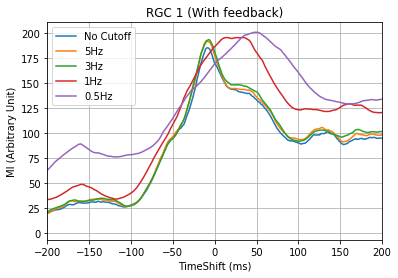

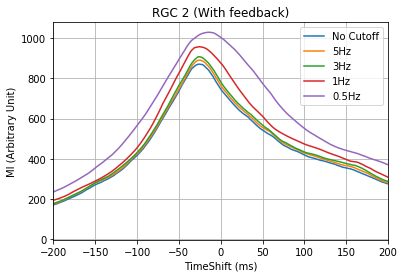

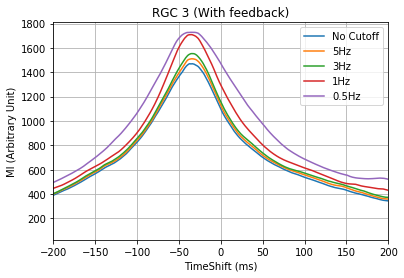

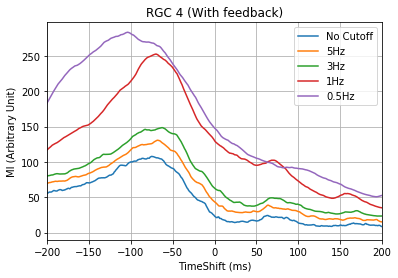

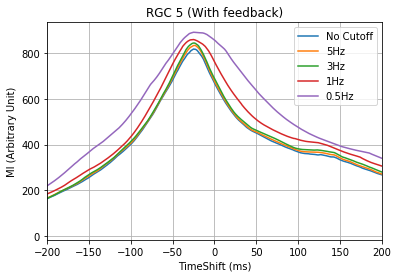

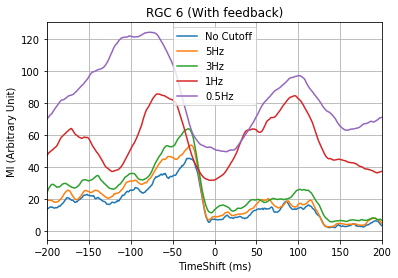

In [38]:
# With feedback
for i in range(len(RGC.weight)):
    MI1_OU = [[] for j in range(len(LPOU))]
    for j in range(len(LPOU)):
        G1_OU = RGC.output(RGC.weight[i], RGC.alpha[i], RGC.theta[i], br1_OU[j]) #feedback
        timeshift,MI1_OU[j] = MI(EqualState(LPOU_0[j],8),EqualState(G1_OU,8),dt,[-1,1])
        plt.plot(timeshift*1000, MI1_OU[j], label = label_list[j]) 
        plt.title("RGC {}".format(i+1)+" (With feedback)")
        plt.legend()
        plt.xlim(-200,200)
        plt.xlabel('TimeShift (ms)')
        plt.ylabel('MI (Arbitrary Unit)')
    plt.grid()
    plt.show()

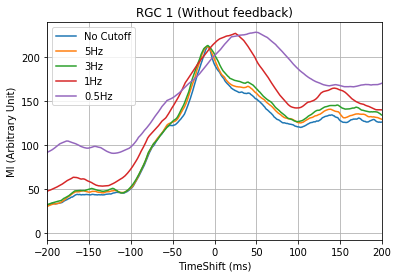

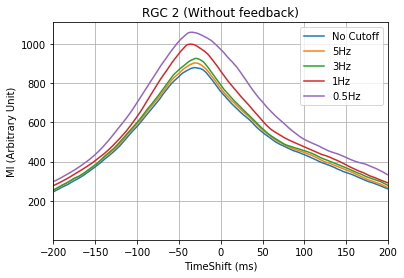

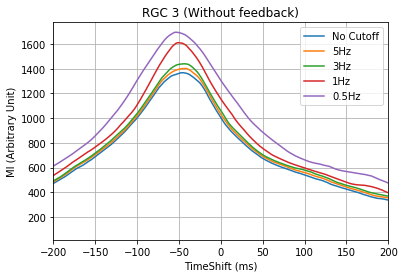

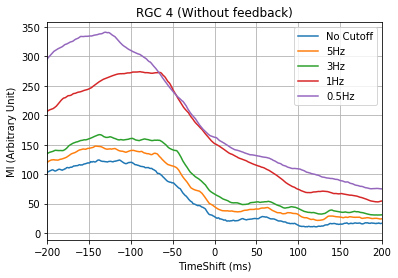

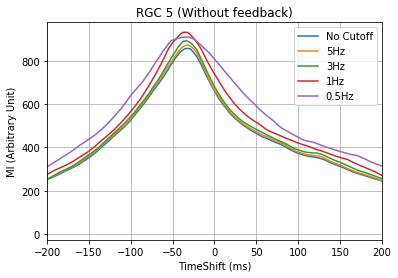

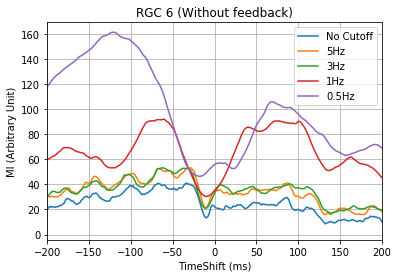

In [39]:
# Without feedback
for i in range(len(RGC.weight)):
    MI0_OU = [[] for j in range(len(LPOU))]
    for j in range(len(LPOU)):
        G0_OU = RGC.output(RGC.weight[i], RGC.alpha[i], RGC.theta[i], br0_OU[j]) #feedback
        timeshift,MI0_OU[j] = MI(EqualState(LPOU_0[j],8),EqualState(G0_OU,8),dt,[-1,1])
        plt.plot(timeshift*1000, MI0_OU[j], label = label_list[j]) 
        plt.title("RGC {}".format(i+1)+" (Without feedback)")
        plt.legend()
        plt.xlabel('TimeShift (ms)')
        plt.ylabel('MI (Arbitrary Unit)')
        plt.xlim(-200,200)

    plt.grid()
    plt.show()